In [103]:
import itertools
## Regular Expression
import re

## Arrays
import numpy as np

## DataFrames
import pandas as pd

## Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

import contractions
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Reading the data and Preparation

In [36]:
#reading the data
df=pd.read_csv('data_capstone_2/nlp_reviews_cleaned.csv', delimiter=',')

#creating the classes
df['rating_class'] = df['rating'].apply(lambda x: 0 if x <= 2 else 1)

#train data set reduced due to capacity of computing
df = df[0:100]
print(df.rating_class.value_counts())

#splitting data set into train and test sets
X = df['clean_text']
y = df['rating_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

1    96
0     4
Name: rating_class, dtype: int64


### Confusion Matrix Function

In [72]:
def confusion_matrix_plot(y_test, y_pred, title, color):
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(6, 6))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=color)
    classNames = ['Bad','Not bad']
    plt.title(title, fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classNames, fontsize=15)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize=15, 
                 fontweight='bold', horizontalalignment="center")
    return plt.show()

# 1. CountVectorizer (Vectorizing the Text)

In [37]:
# Create the word vector with CountVectorizer

count_vect = CountVectorizer(ngram_range=(1,1), min_df=0, max_df=1)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [76]:
# Getting the vocabulary length
print('Vocabulary len :', len(count_vect.get_feature_names()))
print('Longest word   :', max(count_vect.vocabulary_, key=len))

Vocabulary len : 3389
Longest word   : comreviewrmtqopvbaxrefcmcrrypcmtieutfchannelryp


In [77]:
vocab = count_vect.get_feature_names()

## 1.1. Logistic Regression with CountVectorizing

In [38]:
# define the paramater spaces
log_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}
# Instantiate the classifier: logreg
logreg = LogisticRegression()
# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, log_params, cv=5)
# Fit it to the traning set;
logreg_cv.fit(count_vect_train, y_train)
# Predict on the test set;
y_pred_logreg_cv = logreg_cv.predict(count_vect_test)

# Compute and print the scores
print("Tuned Logistic Regression Parameters: {}\n".format(logreg_cv.best_params_)) 
print("Best score is {}\n".format(logreg_cv.best_score_))
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_logreg_cv)))

Tuned Logistic Regression Parameters: {'C': 0.001, 'penalty': 'l2'}

Best score is 0.96

Accuarcy: 0.96



### Classification Report

In [15]:
# Compute and print the classification report
print (classification_report(y_test, y_pred_logreg_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.92      1.00      0.96       229

   micro avg       0.92      0.92      0.92       250
   macro avg       0.46      0.50      0.48       250
weighted avg       0.84      0.92      0.88       250



### Confusion Matrix

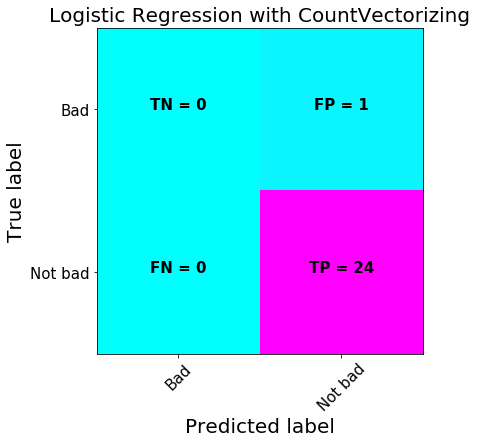

In [73]:
# Plotting the confusion matrix with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_logreg_cv, 
                      title = 'Logistic Regression with CountVectorizing', color=plt.cm.cool)

## 1.2. Linear SVM with CountVectorizing

In [52]:
# Specify the hyperparameter space
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
svm_params = {'C': Cs, 'gamma' : gammas}
# Instantiate the classifier;
svm=SVC(kernel='linear')
# Instantiate the GridSearchCV object;
svm_cv = GridSearchCV(svm, svm_params, cv=5)
# Fit to the training set
svm_cv.fit(count_vect_train, y_train)
# Predict on the test set;
y_pred_svm_cv = svm_cv.predict(count_vect_test)

# Compute and print the scores
print("Linear SVM Best Parameters: {}\n".format(svm_cv.best_params_)) 
print("Best score is {}\n".format(svm_cv.best_score_))
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_svm_cv)))

Linear SVM Best Parameters: {'C': 0.001, 'gamma': 0.001}

Best score is 0.96

Accuarcy: 0.96



### Classification Report

In [104]:
# Compute and print the classification report
print (classification_report(y_test, y_pred_svm_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.92      1.00      0.96       229

   micro avg       0.92      0.92      0.92       250
   macro avg       0.46      0.50      0.48       250
weighted avg       0.84      0.92      0.88       250



### Confusion Matrix

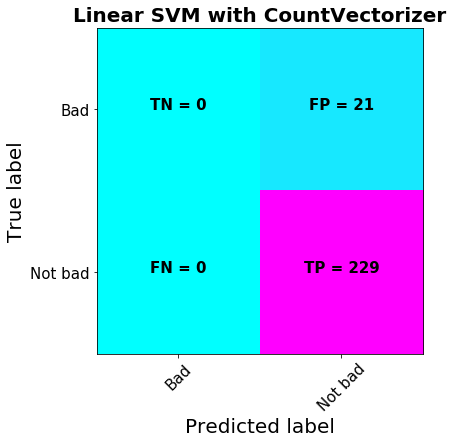

In [105]:
# Plotting the confusion matrix with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_svm_cv, title = 'Linear SVM with CountVectorizer', color=plt.cm.cool)

## 1.3. Naive Bayes with CountVectorizing

In [56]:
# Specify the hyperparameter space;
nb_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 200]}
# Instantiate the classifier;
nb = MultinomialNB()
# Instantiate the GridSearchCV object;
nb_cv = GridSearchCV(nb, nb_params, cv=5)
# Fit to the training set;
nb_cv.fit(count_vect_train, y_train)
# Predict on the test set;
y_pred_nb_cv = nb_cv.predict(count_vect_test)

# Compute and print the scores
print("Naive Bayes Best Parameter: {}\n".format(nb_cv.best_params_)) 
print("Best score is {}\n".format(nb_cv.best_score_))
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_nb_cv)))

Naive Bayes Best Parameter: {'alpha': 100}

Best score is 0.96

Accuarcy: 0.96



### Classification Report

In [113]:
# Compute and print the classification report
print (classification_report(y_test, y_pred_nb_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.92      1.00      0.96       229

   micro avg       0.92      0.92      0.92       250
   macro avg       0.46      0.50      0.48       250
weighted avg       0.84      0.92      0.88       250



### Confusion Matrix

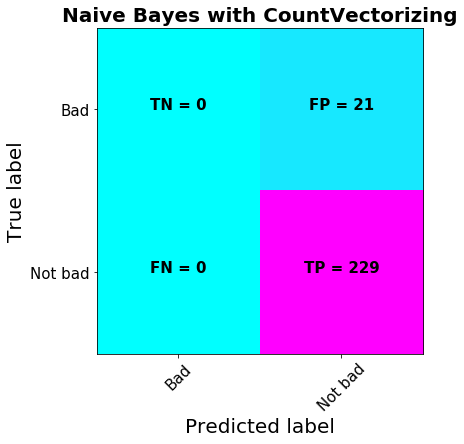

In [115]:
#Plotting the confusion matriz with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_nb_cv, title = 'Naive Bayes with CountVectorizing', color=plt.cm.cool)

## 1.4. Kernel SVM with CountVectorizing

In [54]:
# Specify the hyperparameter space;
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
ksvm_params = {'C': Cs, 'gamma' : gammas}
# Instantiate the classifier;
ksvm=SVC(kernel='rbf')
# Instantiate the GridSearchCV object;
ksvm_cv = GridSearchCV(ksvm, ksvm_params, cv=5)
# Fit to the training set
ksvm_cv.fit(count_vect_train, y_train)
# Predict the labels of the test set;
y_pred_ksvm_cv = ksvm_cv.predict(count_vect_test)

# Compute and print the scores
print("Kernel SVM Best Parameters: {}\n".format(ksvm_cv.best_params_)) 
print("Best score is {}\n".format(ksvm_cv.best_score_))
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_ksvm_cv)))

Kernel SVM Best Parameters: {'C': 0.001, 'gamma': 0.001}

Best score is 0.96

Accuarcy: 0.96



### Classification Report

In [118]:
# Compute and print the classification report
print (classification_report(y_test, y_pred_ksvm_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.92      1.00      0.96       229

   micro avg       0.92      0.92      0.92       250
   macro avg       0.46      0.50      0.48       250
weighted avg       0.84      0.92      0.88       250



### Confusion Matrix

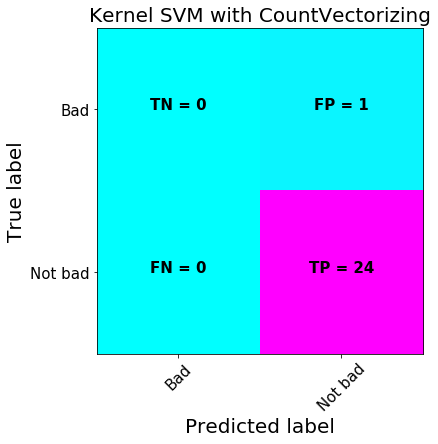

In [74]:
#Plotting the confusion matriz with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_ksvm_cv, title = 'Kernel SVM with CountVectorizing', color=plt.cm.cool)

## 1.5. KNeighbors with CountVectorizing

In [39]:
# define the paramater spaces
knn_params = {'n_neighbors': np.arange(1, 50)}
# Instantiate the classifier: 
knn = KNeighborsClassifier()
# Instantiate the GridSearchCV object;
knn_cv = GridSearchCV(knn, knn_params, cv=5)
# Fit it to the training set;
knn_cv.fit(count_vect_train, y_train)
# Predict on the test set;
y_pred_knn_cv = knn_cv.predict(count_vect_test)

# Compute and print the scores
print("KNN Best Parameters: {}\n".format(knn_cv.best_params_)) 
print("Best score is {}\n".format(knn_cv.best_score_))
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_knn_cv)))

KNN Best Parameters: {'n_neighbors': 1}

Best score is 0.96

Accuarcy: 0.96



### Classification Report

In [40]:
#Compute and print the classification report
print (classification_report(y_test, y_pred_knn_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        24

   micro avg       0.96      0.96      0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



### Confusion Matrix

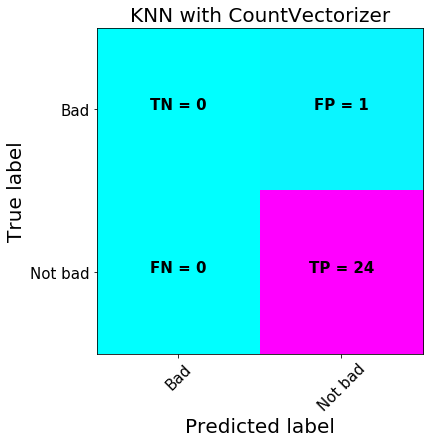

In [75]:
#Plotting the confusion matrix with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_knn_cv, title = 'KNN with CountVectorizer', color=plt.cm.cool)

## 1.6. Random Forest with CountVectorizing

In [43]:
# Hyperparameter optimzation has not been done due to the limitations

# Instantiate the classifier; 
rf_cv = RandomForestClassifier(n_estimators = 200, random_state=5)

# Fit to the training set;
rf_cv.fit(count_vect_train, y_train)

# Predict on the test set;
y_pred_rf_cv = rf_cv.predict(count_vect_test)

# Compute and print the accuracy
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_rf_cv)))

Accuarcy: 0.96



### Classification Report

In [44]:
print (classification_report(y_test, y_pred_rf_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        24

   micro avg       0.96      0.96      0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



### Confusion Matrix

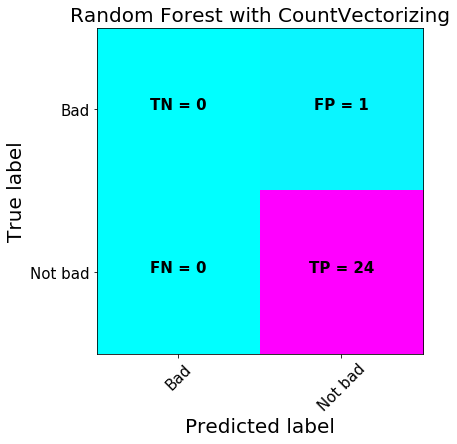

In [76]:
#Plotting the confusion matriz with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_rf_cv, title = 'Random Forest with CountVectorizing', color=plt.cm.cool)

## 1.7. Gradient Boosting with CountVectorizing

In [47]:
# Hyperparameter optimzation has not been done due to the limitations

# Instantiate the classifier; 
gb_cv = GradientBoostingClassifier()

# Fit to the training set
gb_cv.fit(count_vect_train, y_train)

# Predict on the test set;
y_pred_gb_cv = gb_cv.predict(count_vect_test)

# Compute and print the accuracy
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_gb_cv)))

Accuarcy: 0.96



### Classification Report

In [48]:
print (classification_report(y_test, y_pred_gb_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        24

   micro avg       0.96      0.96      0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



### Confusion Matrix

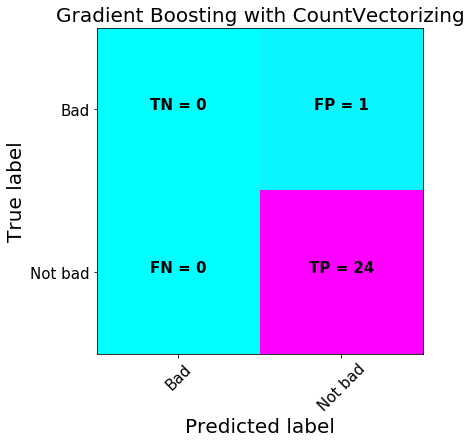

In [77]:
#Plotting the confusion matriz with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_gb_cv, title = 'Gradient Boosting with CountVectorizing', color=plt.cm.cool)

## 1.8. Comparision of CountVectorizing

### Functions for Comparision 

In [50]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['avg / total'] = avg

    return class_report_df.T

# Function for adding explanatory columns and organizing all dataframe
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df = df[:2]
    df['class']=['bad', 'not bad']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [144]:
#For loop for using "comparison functions" on "CountVectorizing" results

frames_cv = [] # empty list for collecting dataframes
y_preds_cv = [y_pred_logreg_cv, y_pred_svm_cv, y_pred_ksvm_cv, 
           y_pred_nb_cv, y_pred_knn_cv, y_pred_rf_cv, y_pred_gb_cv] #list for y_preds
labels_cv = ['LogReg', 'SVM', 'Kernel SVM', 'Naive Bayes', 'KNN', 'RForest', 'GBoost'] # list for labels
vector_cv = 'CountVect'
for y_pred, label in zip(y_preds_cv, labels_cv):
    df = comparison_matrix(y_test, y_pred, label, vector_cv)
    frames_cv.append(df)

# concatenating all dataframes
df_cv = pd.concat(frames)

df_cv2 = df_cv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

### Comparison Table - CountVectorizing

In [145]:
# Print the comparision table
print('\nComparision Matrix of Modeling with CountVectorizing\n\n{}\n'.format(df_cv2))


Comparision Matrix of Modeling with CountVectorizing

                                         precision  recall  f1-score  support
vectorizer model       accuracy class                                        
CountVect  LogReg      0.96     bad           0.00     0.0  0.000000      1.0
                                not bad       0.96     1.0  0.979592     24.0
           SVM         0.96     bad           0.00     0.0  0.000000      1.0
                                not bad       0.96     1.0  0.979592     24.0
           Kernel SVM  0.96     bad           0.00     0.0  0.000000      1.0
                                not bad       0.96     1.0  0.979592     24.0
           Naive Bayes 0.96     bad           0.00     0.0  0.000000      1.0
                                not bad       0.96     1.0  0.979592     24.0
           KNN         0.96     bad           0.00     0.0  0.000000      1.0
                                not bad       0.96     1.0  0.979592     24.0
         

# 2. TfidfVectorizer

In [58]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1), min_df=0, max_df=1, use_idf=True)
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

## 2.1. Logistic Regression with TfidfVectorizing

In [62]:
# Instantiate a logistic regression classifier: with already defined best parameters
logreg_tv = LogisticRegression(C=0.001, penalty='l2')
# Fit it to the data
logreg_tv.fit(tfidf_vect_train, y_train)
# Predict on the test data
y_pred_logreg_tv = logreg_tv.predict(tfidf_vect_test)

# Compute and print the accuracy
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_logreg_tv)))

Accuarcy: 0.96



### Classification_report

In [63]:
#Compute and print the classification report
print (classification_report(y_test, y_pred_logreg_tv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        24

   micro avg       0.96      0.96      0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



### Confusion Matrix

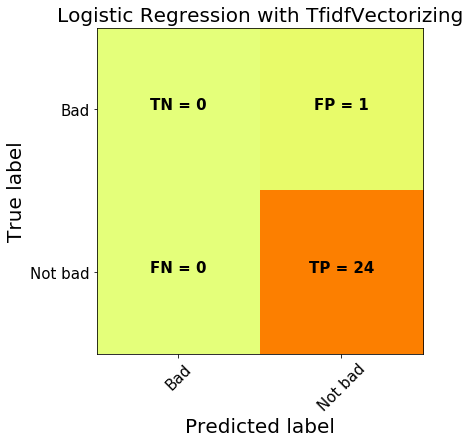

In [80]:
#Plotting the confusion matrix with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_logreg_tv, 
                      title = 'Logistic Regression with TfidfVectorizing', color=plt.cm.Wistia)

## 2.2. Linear SVM with TfidfVectorizing

In [65]:
# Instantiate a SVC classifier: with already defined best parameters
svm_tv=SVC(kernel='linear', C=0.001, gamma=0.001)
# Fit to the training set
svm_tv.fit(tfidf_vect_train, y_train)
# Predict on the test data
y_pred_svm_tv = svm_tv.predict(tfidf_vect_test)

# Compute and print the accuracy
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_svm_tv)))

Accuarcy: 0.96



### Classification Report

In [66]:
#Compute and print the classification report
print (classification_report(y_test, y_pred_svm_tv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        24

   micro avg       0.96      0.96      0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



### Confusion Matrix

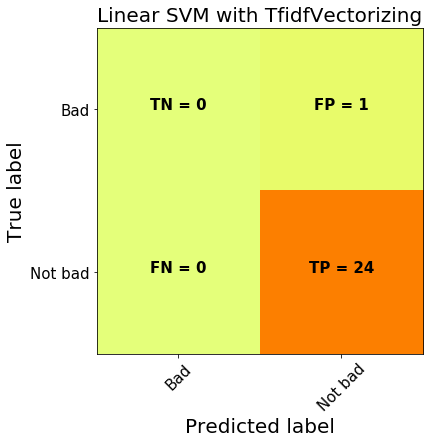

In [81]:
#Plotting the confusion matrix with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_svm_tv, 
                      title = 'Linear SVM with TfidfVectorizing', color=plt.cm.Wistia)

## 2.3. Naive Bayes with TfidfVectorizing

In [70]:
# Instantiate a naive bayes classifier:
nb_tv = MultinomialNB(alpha=100)
# Fit to the training set
nb_tv.fit(tfidf_vect_train, y_train)
# Predict the labels of the test set: y_pred
y_pred_nb_tv = nb_tv.predict(tfidf_vect_test)

# Compute and print the accuracy
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_nb_tv)))

Accuarcy: 0.96



### Classification Report

In [71]:
#Compute and print the classification report
print (classification_report(y_test, y_pred_nb_tv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        24

   micro avg       0.96      0.96      0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



### Confusion Matrix

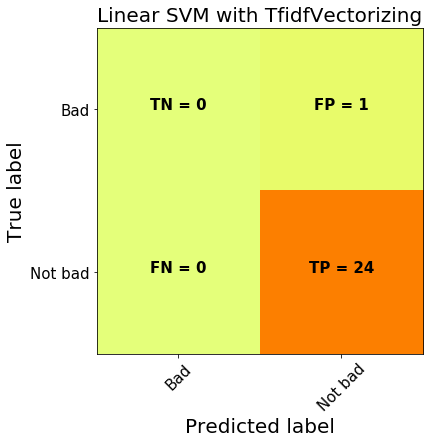

In [82]:
#Plotting the confusion matrix with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_nb_tv, 
                      title = 'Naive Bayes with TfidfVectorizing', color=plt.cm.Wistia)

## 2.4. Kernel SVM with TfidfVectorizing

In [83]:
# Instantiate a naive bayes classifier:
ksvm_tv = SVC(kernel='rbf', C=0.001, gamma=0.001)
# Fit to the training set
ksvm_tv.fit(tfidf_vect_train, y_train)
# Predict the labels of the test set: y_pred
y_pred_ksvm_tv = ksvm_tv.predict(tfidf_vect_test)

# Compute and print the accuracy
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_ksvm_tv)))

Accuarcy: 0.96



### Classification report

In [85]:
#Compute and print the classification report
print (classification_report(y_test, y_pred_ksvm_tv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        24

   micro avg       0.96      0.96      0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



### Confusion Matrix

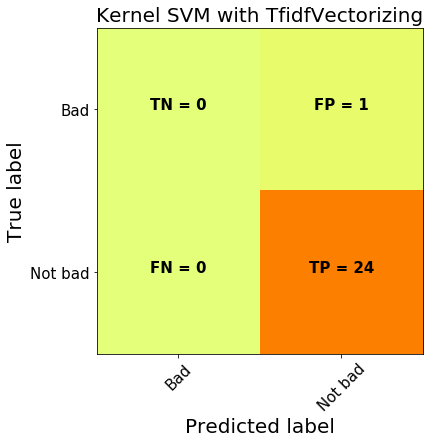

In [86]:
#Plotting the confusion matrix with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_ksvm_tv, 
                      title = 'Kernel SVM with TfidfVectorizing', color=plt.cm.Wistia)

## 2.5. KNN Classifier with TfidfVectorizing

In [121]:
# Instantiate the classifier: 
knn_tv = KNeighborsClassifier(n_neighbors=2)
# Fit it to the data
knn_tv.fit(tfidf_vect_train, y_train)
# Predict on the test data
y_pred_knn_tv = knn_tv.predict(tfidf_vect_test)

# Compute and print the scores
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_knn_tv)))

Accuarcy: 0.96



### Classification report

In [88]:
#Compute and print the classification report
print (classification_report(y_test, y_pred_knn_tv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        24

   micro avg       0.96      0.96      0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



### Confusion Matrix

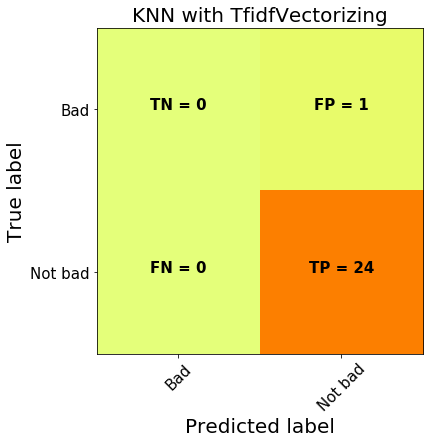

In [90]:
#Plotting the confusion matrix with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_knn_tv, 
                      title = 'KNN with TfidfVectorizing', color=plt.cm.Wistia)

## 2.6. Random Forest with TfidfVectorizing

In [91]:
# Instantiate the classifier: 
rf_tv = RandomForestClassifier(n_estimators = 200, random_state=5)
# Fit to the training set
rf_tv.fit(tfidf_vect_train, y_train)
# Predict the labels of the test set: y_pred
y_pred_rf_tv = rf_tv.predict(tfidf_vect_test)

# Compute and print the accuracy
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_rf_tv)))

Accuarcy: 0.96



### Classification report

In [92]:
#Compute and print the classification report
print (classification_report(y_test, y_pred_rf_tv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        24

   micro avg       0.96      0.96      0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



### Confusion Matrix

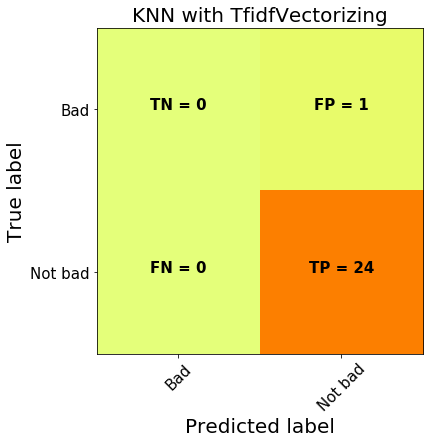

In [93]:
#Plotting the confusion matrix with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_rf_tv, 
                      title = 'KNN with TfidfVectorizing', color=plt.cm.Wistia)

## 2.7. GradientBoosting with TfidfVectorizing

In [96]:
# Instantiate the classifier; 
gb_tv = GradientBoostingClassifier()

# Fit to the training set
gb_tv.fit(tfidf_vect_train, y_train)

# Predict on the test set;
y_pred_gb_tv = gb_tv.predict(tfidf_vect_test)

# Compute and print the accuracy
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_gb_tv)))

Accuarcy: 0.96



### Classification report

In [98]:
#Compute and print the classification report
print (classification_report(y_test, y_pred_gb_tv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        24

   micro avg       0.96      0.96      0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



### Confusion Matrix

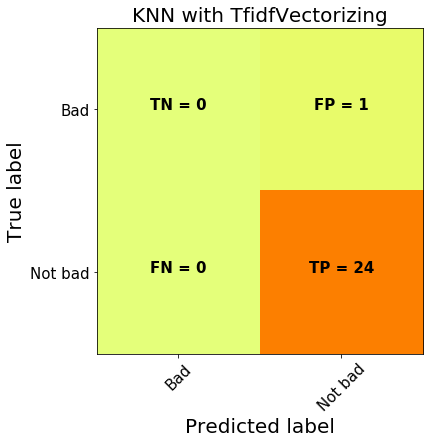

In [97]:
#Plotting the confusion matrix with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_gb_tv, 
                      title = 'KNN with TfidfVectorizing', color=plt.cm.Wistia)

## 2.8. Comparision of TfidfVectorizing

In [146]:
#For loop for using "comparison functions" on "TfidfVectorizing" results

frames_tv = [] # empty list for collecting dataframes
y_preds_tv = [y_pred_logreg_tv, y_pred_svm_tv, y_pred_ksvm_tv, 
           y_pred_nb_tv, y_pred_knn_tv, y_pred_rf_tv, y_pred_gb_tv] #list for y_preds
labels_tv = ['LogReg', 'SVM', 'Kernel SVM', 'Naive Bayes', 'KNN', 'RForest', 'GBoost'] # list for labels
vector_tv = 'TfidfVect'
for y_pred, label in zip(y_preds_tv, labels_tv):
    df = comparison_matrix(y_test, y_pred, label, vector_tv)
    frames_tv.append(df)

# concatenating all dataframes
df_tv = pd.concat(frames_tv)

df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

### Comparison table - TfidfVectorizing

In [147]:
# Print the comparision matrix
print('\nComparision Matrix of Modeling with TfidfVectorizing\n\n{}\n'.format(df_tv2))


Comparision Matrix of Modeling with TfidfVectorizing

                                         precision  recall  f1-score  support
vectorizer model       accuracy class                                        
TfidfVect  LogReg      0.96     bad           0.00     0.0  0.000000      1.0
                                not bad       0.96     1.0  0.979592     24.0
           SVM         0.96     bad           0.00     0.0  0.000000      1.0
                                not bad       0.96     1.0  0.979592     24.0
           Kernel SVM  0.96     bad           0.00     0.0  0.000000      1.0
                                not bad       0.96     1.0  0.979592     24.0
           Naive Bayes 0.96     bad           0.00     0.0  0.000000      1.0
                                not bad       0.96     1.0  0.979592     24.0
           KNN         0.96     bad           0.00     0.0  0.000000      1.0
                                not bad       0.96     1.0  0.979592     24.0
         

# 3. HashingVectorizer

In [104]:
hash_vect = HashingVectorizer(n_features=2000, ngram_range=(1,1))
hash_vect_train = hash_vect.fit_transform(X_train)
hash_vect_train = hash_vect_train.toarray()
hash_vect_test = hash_vect.transform(X_test)
hash_vect_test = hash_vect_test.toarray()

## 3.1. Logistic Regression with HashingVectorizing

In [105]:
# Instantiate a logistic regression classifier: with already defined best parameters
logreg_hv = LogisticRegression(C=0.001, penalty='l2')
# Fit it to the data
logreg_hv.fit(hash_vect_train, y_train)
# Predict on the test data
y_pred_logreg_hv = logreg_hv.predict(hash_vect_test)

# Compute and print the accuracy
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_logreg_hv)))

Accuarcy: 0.96



### Classification report

In [111]:
#Compute and print the classification report
print (classification_report(y_test, y_pred_logreg_hv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        24

   micro avg       0.96      0.96      0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



### Confusion Matrix

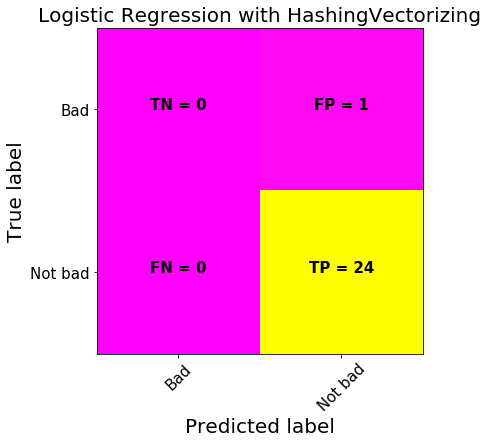

In [116]:
#Plotting the confusion matrix with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_logreg_hv, 
                      title = 'Logistic Regression with HashingVectorizing', color=plt.cm.spring)

## 3.2. Linear SVM with HashingVectorizing

In [110]:
# Instantiate a SVC classifier: with already defined best parameters
svm_hv=SVC(kernel='linear', C=0.001, gamma=0.001)
# Fit to the training set
svm_hv.fit(hash_vect_train, y_train)
# Predict on the test data
y_pred_svm_hv = svm_hv.predict(hash_vect_test)

# Compute and print the accuracy
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_svm_hv)))

Accuarcy: 0.96



### Classification report

In [113]:
#Compute and print the classification report
print (classification_report(y_test, y_pred_svm_hv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        24

   micro avg       0.96      0.96      0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



### Confusion Matrix

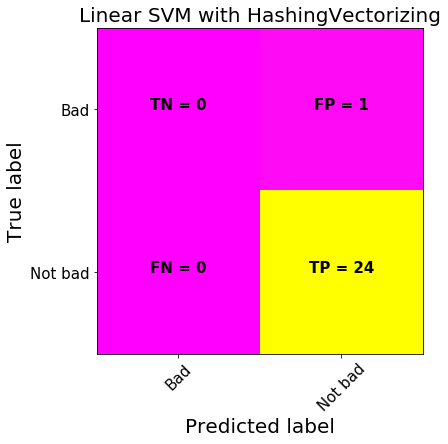

In [115]:
#Plotting the confusion matrix with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_svm_hv, 
                      title = 'Linear SVM with HashingVectorizing', color=plt.cm.spring)

## 3.3. Kernel SVM with HashVectorizing

In [118]:
# Instantiate a naive bayes classifier:
ksvm_hv = SVC(kernel='rbf', C=0.001, gamma=0.001)
# Fit to the training set
ksvm_hv.fit(hash_vect_train, y_train)
# Predict the labels of the test set: y_pred
y_pred_ksvm_hv = ksvm_hv.predict(hash_vect_test)

# Compute and print the accuracy
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_ksvm_hv)))

Accuarcy: 0.96



### Classification report

In [119]:
#Compute and print the classification report
print (classification_report(y_test, y_pred_ksvm_hv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        24

   micro avg       0.96      0.96      0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



### Confusion Matrix

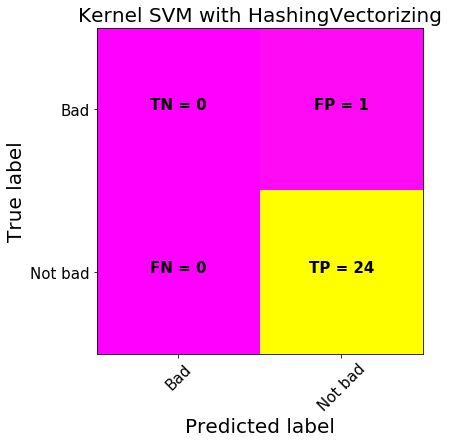

In [120]:
#Plotting the confusion matrix with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_ksvm_hv, 
                      title = 'Kernel SVM with HashingVectorizing', color=plt.cm.spring)

## 3.4. KNN Classifier with HashVectorizing

In [122]:
# Instantiate the classifier: 
knn_hv = KNeighborsClassifier(n_neighbors=2)
# Fit it to the data
knn_hv.fit(hash_vect_train, y_train)
# Predict on the test data
y_pred_knn_hv = knn_hv.predict(hash_vect_test)

# Compute and print the scores
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_knn_hv)))

Accuarcy: 0.72



### Classification report

In [123]:
#Compute and print the classification report
print (classification_report(y_test, y_pred_knn_hv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.95      0.75      0.84        24

   micro avg       0.72      0.72      0.72        25
   macro avg       0.47      0.38      0.42        25
weighted avg       0.91      0.72      0.80        25



### Confusion Matrix

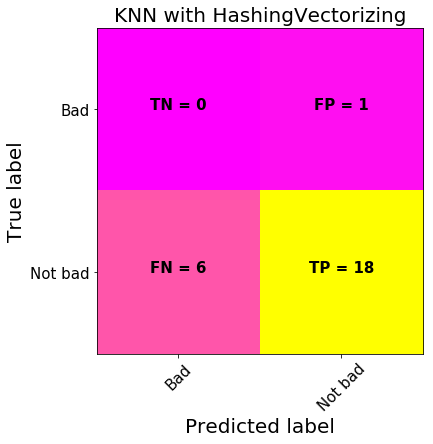

In [124]:
#Plotting the confusion matrix with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_knn_hv, 
                      title = 'KNN with HashingVectorizing', color=plt.cm.spring)

## 3.5. Random Forest with HasVectorizing

In [125]:
# Instantiate the classifier: 
rf_hv = RandomForestClassifier(n_estimators = 200, random_state=5)
# Fit to the training set
rf_hv.fit(hash_vect_train, y_train)
# Predict the labels of the test set: y_pred
y_pred_rf_hv = rf_hv.predict(hash_vect_test)

# Compute and print the accuracy
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_rf_hv)))

Accuarcy: 0.96



### Classification report

In [126]:
# Compute and print the classification report
print (classification_report(y_test, y_pred_rf_hv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        24

   micro avg       0.96      0.96      0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



### Confusion Matrix

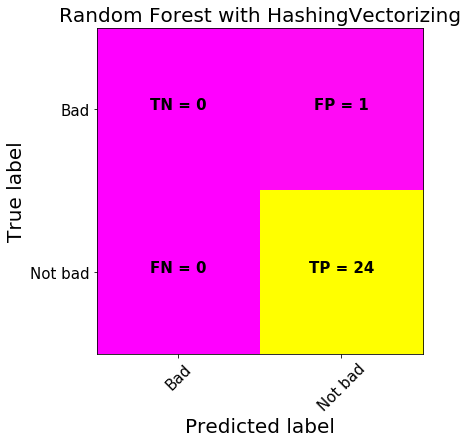

In [127]:
#Plotting the confusion matrix with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_rf_hv, 
                      title = 'Random Forest with HashingVectorizing', color=plt.cm.spring)

## 3.6. GradientBoosting with HashVectorizing

In [128]:
# Instantiate the classifier; 
gb_hv = GradientBoostingClassifier()

# Fit to the training set
gb_hv.fit(hash_vect_train, y_train)

# Predict on the test set;
y_pred_gb_hv = gb_hv.predict(hash_vect_test)

# Compute and print the accuracy
print('Accuarcy: {}\n'.format(metrics.accuracy_score(y_test, y_pred_gb_hv)))

Accuarcy: 0.96



### Classification report

In [129]:
# Compute and print the classification report
print (classification_report(y_test, y_pred_gb_hv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        24

   micro avg       0.96      0.96      0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



### Confusion Matrix

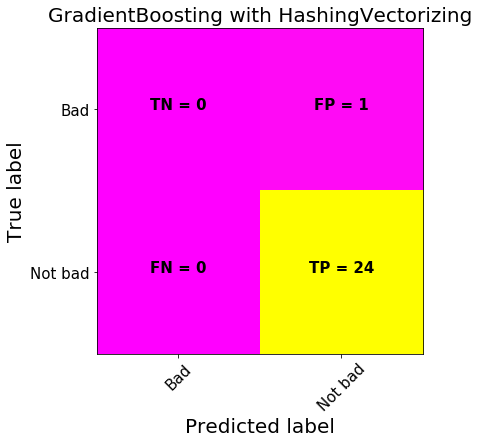

In [130]:
#Plotting the confusion matrix with "confusion_matrix_plot" function
confusion_matrix_plot(y_test, y_pred_gb_hv, 
                      title = 'GradientBoosting with HashingVectorizing', color=plt.cm.spring)

## 3.7. Comparison of HashingVectorizing

In [148]:
#For loop for using "comparison functions" on "HashingVectorizing" results

frames_hv = [] # empty list for collecting dataframes
y_preds_hv = [y_pred_logreg_hv, y_pred_svm_hv, y_pred_ksvm_hv,
           y_pred_knn_hv, y_pred_rf_hv, y_pred_gb_hv] #list for y_preds
labels_hv = ['LogReg', 'SVM', 'Kernel SVM', 'KNN', 'RForest', 'GBoost'] # list for labels
vector_hv = 'HashVect'
for y_pred, label in zip(y_preds_hv, labels_hv):
    df = comparison_matrix(y_test, y_pred, label, vector_hv)
    frames_hv.append(df)

# concatenating all dataframes
df_hv = pd.concat(frames_hv)

df_hv2 = df_hv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

### Comparision Table

In [149]:
# Print the comparision matrix
print('\nComparision Matrix of Modeling with HashingVectorizing\n\n{}\n'.format(df_hv2))


Comparision Matrix of Modeling with HashingVectorizing

                                        precision  recall  f1-score  support
vectorizer model      accuracy class                                        
HashVect   LogReg     0.96     bad       0.000000    0.00  0.000000      1.0
                               not bad   0.960000    1.00  0.979592     24.0
           SVM        0.96     bad       0.000000    0.00  0.000000      1.0
                               not bad   0.960000    1.00  0.979592     24.0
           Kernel SVM 0.96     bad       0.000000    0.00  0.000000      1.0
                               not bad   0.960000    1.00  0.979592     24.0
           KNN        0.72     bad       0.000000    0.00  0.000000      1.0
                               not bad   0.947368    0.75  0.837209     24.0
           RForest    0.96     bad       0.000000    0.00  0.000000      1.0
                               not bad   0.960000    1.00  0.979592     24.0
           GBoost  

# All Together

In [152]:
frames_all = frames_cv + frames_tv + frames_hv
df_all = pd.concat(frames_all)
df_all2 = df_all.set_index(['vectorizer', 'model', 'accuracy', 'class'])
print('\nComparision Table of All BOW Vectorizers\n\n{}\n'.format(df_all2))


Comparision Table of All BOW Vectorizers

                                         precision  recall  f1-score  support
vectorizer model       accuracy class                                        
CountVect  LogReg      0.96     bad       0.000000    0.00  0.000000      1.0
                                not bad   0.960000    1.00  0.979592     24.0
           SVM         0.96     bad       0.000000    0.00  0.000000      1.0
                                not bad   0.960000    1.00  0.979592     24.0
           Kernel SVM  0.96     bad       0.000000    0.00  0.000000      1.0
                                not bad   0.960000    1.00  0.979592     24.0
           Naive Bayes 0.96     bad       0.000000    0.00  0.000000      1.0
                                not bad   0.960000    1.00  0.979592     24.0
           KNN         0.96     bad       0.000000    0.00  0.000000      1.0
                                not bad   0.960000    1.00  0.979592     24.0
           RForest   